<a href="https://colab.research.google.com/github/filipp134/vk_bot_detection/blob/forth_version/vk_bot_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import networkx as nx
import pandas as pd
from datetime import datetime
from statistics import *
import math

BASIC_LINK = 'https://api.vk.com/method/'
ACCESS_TOKEN = ''

In [ ]:
def get_user_info(user_id):
    '''Получение информации в виде словаря о пользователе ВКонтакте с user_id.'''
    method = 'users.get?user_ids={user_ids}&fields={fields}&access_token={access_token}&v={api_version}'
    payload = {
        'user_ids' : [user_id],
        'fields': ','.join(['city', 'sex', 'bdate', 'followers_count', 'has_mobile', 'personal']),
        'v':'5.130',
        'access_token' : ACCESS_TOKEN
    }
    response = requests.get(BASIC_LINK + method, params=payload).json()
    info = response['response'][0]
    return info

In [ ]:
def get_group_id(group_name):
    '''Получение id группы из названия группы, указанного в ссылке по типу https://vk.com/whoinrussia'''
    method = 'utils.resolveScreenName?screen_name={screen_name}&access_token={access_token}&v={api_version}'
    payload = {'screen_name' : group_name, 'access_token' : ACCESS_TOKEN, 'v':'5.130'}
    response = requests.get(BASIC_LINK + method, params=payload).json()
    return response['response']['object_id']

In [ ]:
def get_members_ids(group_name):
  '''Получение id 1000 членов группы по названию группы'''
  method = 'groups.getMembers?group_id={group_id}&access_token={access_token}&v={api_version}'
  group_id = get_group_id(group_name)
  payload = {
        'group_id' : group_id,
        'v':'5.130',
        'access_token' : ACCESS_TOKEN
    }
  response = requests.get(BASIC_LINK + method, params=payload).json()
  return response['response']['items']

In [ ]:
def get_friends_ids(user_id):
  '''Получение списка id друзей пользователя ВКонтакте с user_id.'''
  method = 'friends.get?user_id={user_id}&fields={fields}&count={count}&offset={offset}&access_token={access_token}&v={api_version}'
  payload = {
        'user_id' : user_id,
        'order':'name',
        'count' : 1000,
        'offset' : 10,
        'fields': ','.join(['city', 'country', 'sex', 'last_seen']),
        'v':'5.130',
        'access_token' : ACCESS_TOKEN
    }
  response = requests.get(BASIC_LINK + method, params=payload).json()
  friends_ids = []
  try:
    for i in range(len(response['response']['items'])):
      friends_ids.append(response['response']['items'][i]['id'])
  except:
      friends_ids.append(0)
  return friends_ids

In [ ]:
def make_graph(user_id_1): 
  '''Создание графа друзей Вконтакте пользователя с user_id.'''
  graph = nx.Graph()
  graph.add_node(user_id_1)
  friends_ids = set(get_friends_ids(user_id_1))
  for friend_id in friends_ids:
    graph.add_edge(user_id_1, friend_id)
    friends_ids_2nd_gen = get_friends_ids(friend_id)
    for friend_id_2nd_gen in friends_ids_2nd_gen:
        if friend_id_2nd_gen in friends_ids:
            graph.add_edge(friend_id_2nd_gen, friend_id)
  return graph

In [ ]:
def get_graph_features(graph, user_id): 
    id_degree = graph.degree(user_id)
    avg_cl = nx.average_clustering(graph)
    trans = nx.transitivity(graph)
    deg_centr = mean(nx.degree_centrality(graph).values())
    return (id_degree, avg_cl, trans, deg_centr)

In [ ]:
def draw_graph(graph):
  '''Построение графа graph c красным цветом вершин без названий.'''
  nx.draw_circular(graph, node_color='red', node_size=500, with_labels=False)

In [ ]:
def receive_age(user_id):
  try:
    b_year = int(get_user_info(user_id)['bdate'][len(get_user_info(user_id)['bdate'])-4:])
    t_year = int(datetime.today().strftime('%Y-%m-%d')[:4])
    return t_year - b_year
  except:
    return 0

In [ ]:
def return_city(user_id):
    try:
      city_id = get_user_info(user_id)['city']['id']
      return city_id
    except:
      return 0

In [ ]:
def receive_sex(user_id):
    sex = get_user_info(user_id)['sex']
    return sex

In [ ]:
def receive_pol_att(user_id):
    try:
        info = get_user_info(user_id)
        try:
            pol = info['personal']['political']
            return 1
        except:
            return 0
    except:
        return None

In [ ]:
def receive_sm_att(user_id):
    try:
        info = get_user_info(user_id)
        try:
            sm = info['personal']['smoking']
            return 1
        except:
            return 0
    except:
        return None

In [ ]:
def receive_alc_att(user_id):
    try:
        info = get_user_info(user_id)
        try:
            sm = info['personal']['alcohol']
            return 1
        except:
            return 0
    except:
        return None

In [ ]:
def receive_religion(user_id):
    try:
        info = get_user_info(user_id)
        try:
            rel = info['personal']['religion']
            return 1
        except:
            return 0
    except:
        return None

In [ ]:
def receive_langs(user_id):
    try:
        info = get_user_info(user_id)
        try:
            rel = info['personal']['langs']
            return 1
        except:
            return 0
    except:
        return None

In [ ]:
def return_followers_count(user_id):
  try:
    fol = get_user_info(user_id)['followers_count']
    return fol
  except:
    return None

In [ ]:
def return_phone_possesion(user_id):
  try:
    phone = get_user_info(user_id)['has_mobile']
    return phone
  except:
    return 1

In [ ]:
def get_basic_comm_info(user_id):
    friends_ids = get_friends_ids(user_id)
    city_of_user = str(return_city(user_id))
    age_of_user = receive_age(user_id)
    try:
        sex_of_user = str(receive_sex(user_id))
    except:
        pass
    n_of_friends = len(friends_ids)
    cities = dict()
    for friend in friends_ids:
        city = str(return_city(friend))
        try:
            cities[city] += 1
        except:
            cities[city] = 1
    friends_in_same_city = cities.get(city_of_user, 0) / n_of_friends
    ages = []
    for friend in friends_ids:
        ages.append(receive_age(friend))
    while None in ages:
        ages.remove(None)
    age_diff = abs(age_of_user - mean(ages))
    try:
        sexes = dict()
        for friend in friends_ids:
            try:
                sex = str(receive_sex(friend))
            except:
                pass
            try:
                sexes[sex] += 1
            except:
                try:
                    sexes[sex] = 1
                except:
                    pass
        friends_of_same_sex = sexes[sex_of_user] / n_of_friends
    except:
        pass
    try:
        return (friends_in_same_city, age_diff, friends_of_same_sex)
    except:
        return (friends_in_same_city, age_diff)

In [ ]:
def add_row_csv(user_id):
    with open('VK_profiles_info.txt', 'a') as file:
        text = f'\n{user_id},{return_city(user_id)},{receive_age(user_id)},{receive_sex(user_id)},'
        text += f'{return_followers_count(user_id)},'
        text += f'{return_phone_possesion(user_id)},'
        graph = make_graph(user_id)
        feat = get_graph_features(graph, user_id)
        text += f'{feat[0]},{feat[1]},{feat[2]},{feat[3]},'
        text += f'{receive_religion(user_id)},{receive_pol_att(user_id)},'
        text += f'{receive_sm_att(user_id)},{receive_alc_att(user_id)},{receive_langs(user_id)},'
#        try:
#          text += f'{get_basic_comm_info(user_id)[0]},{get_basic_comm_info(user_id)[1]},{get_basic_comm_info(user_id)[2]}'
#        except:
#          text += f'0,0,0'
        file.write(text)
        file.close()

In [ ]:
ids = [6,
11,
46,
47,
102,
150,
177,
196,
200,
380]
for id in ids:
  add_row_csv(id)

NetworkXError: ignored

In [ ]:
df = pd.read_csv('VK_profiles_info.txt', sep=',')
df.followers_count.replace(to_replace='None', value=0, inplace=True)
df['followers_count'] = df['followers_count'].astype(int)
df

,user_id,city,age,sex,followers_count,has_phone,has_religion_info,has_political_info,has_smoking_info,has_alcohol_info,has_language_info,id_degree,avg_clustering,transitivity,degree_centrality
0,411664440,1,29,1,21,1,0,0,1,1,0,83,0.682265,0.530256,0.210270
1,36414701,1386,0,2,30,1,1,1,0,0,0,273,0.563324,0.254903,0.042967
2,349141859,1,17,2,55,1,1,0,1,1,1,715,0.553135,0.287143,0.039430
3,19252637,1,30,2,65,1,0,0,0,0,0,296,0.627046,0.287198,0.055465
4,185367006,1,0,1,0,1,0,0,0,0,0,1,0.000000,0.000000,1.000000
5,491289055,1,15,1,5,1,0,1,1,1,1,96,0.682357,0.568537,0.197165
6,492282422,0,14,1,40,1,0,0,1,1,1,196,0.527439,0.328449,0.072879
7,400131515,0,17,1,30,1,0,0,0,0,0,72,0.699751,0.449703,0.151446
8,396009712,0,0,2,41,1,0,0,0,0,0,210,0.587430,0.396109,0.091040
9,136987897,1,0,2,0,1,0,0,0,0,0,1,0.000000,0.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             10 non-null     int64  
 1   city                10 non-null     int64  
 2   age                 10 non-null     int64  
 3   sex                 10 non-null     int64  
 4   followers_count     10 non-null     int64  
 5   has_phone           10 non-null     int64  
 6   has_religion_info   10 non-null     int64  
 7   has_political_info  10 non-null     int64  
 8   has_smoking_info    10 non-null     int64  
 9   has_alcohol_info    10 non-null     int64  
 10  has_language_info   10 non-null     int64  
 11  id_degree           10 non-null     int64  
 12  avg_clustering      10 non-null     float64
 13  transitivity        10 non-null     float64
 14  degree_centrality   10 non-null     float64
dtypes: float64(3), int64(12)
memory usage: 1.3 KB


In [ ]:
df.describe()

,user_id,city,age,sex,followers_count,has_phone,has_religion_info,has_political_info,has_smoking_info,has_alcohol_info,has_language_info,id_degree,avg_clustering,transitivity,degree_centrality
count,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.918541e+08,139.200000,12.200000,1.500000,28.700000,1.0,0.200000,0.200000,0.400000,0.400000,0.300000,194.300000,0.492275,0.310230,0.286066
std,1.810582e+08,438.081119,11.792653,0.527046,22.509504,0.0,0.421637,0.421637,0.516398,0.516398,0.483046,210.726811,0.266072,0.194051,0.381191
min,1.925264e+07,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.039430
25%,1.490827e+08,0.250000,0.000000,1.000000,9.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,74.750000,0.533863,0.262963,0.059818
50%,3.725758e+08,1.000000,14.500000,1.500000,30.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,146.000000,0.575377,0.307824,0.121243
75%,4.087812e+08,1.000000,17.000000,2.000000,40.750000,1.0,0.000000,0.000000,1.000000,1.000000,0.750000,257.250000,0.668461,0.436304,0.206993
max,4.922824e+08,1386.000000,30.000000,2.000000,65.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,715.000000,0.699751,0.568537,1.000000


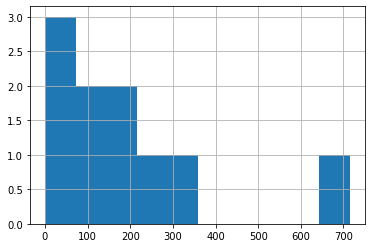

In [ ]:
df.id_degree.hist()

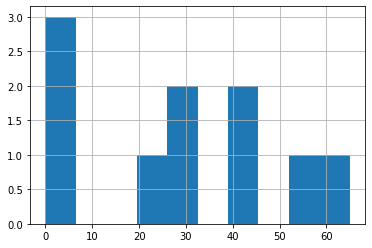

In [ ]:
df.followers_count.hist()

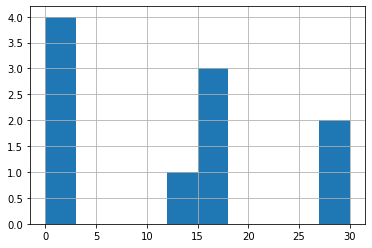

In [ ]:
df.age.hist()

In [ ]:
with open('1000_member_ids_of_RIA_News.txt', 'a') as file:
  for id in get_members_ids('ria'):
    file.write(f'\n{id},0')